In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,roc_auc_score,auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# turn debug mode on or off
DEBUG = False
# let random state fixed
RANDOM_STATE = 42


In [3]:
# display data information
def data_info(df):
    data = pd.DataFrame()
    data['column'] = df.columns.tolist()
    data['non_null_number'] = df.count().values
    data['null_number'] = df.isnull().sum().values
    data['null_percent'] = data['null_number'] * 100 / df.shape[0]
    data['dtype'] = df.dtypes.values
    data.set_index('column', inplace=True)
    return data

In [4]:
# read train and test data files
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
print("train_identity shape: ", train_identity.shape)
print("train_transaction shape: ", train_transaction.shape)
print("test_identity shape: ", test_identity.shape)
print("test_transaction shape: ", test_transaction.shape)

train_identity shape:  (144233, 41)
train_transaction shape:  (590540, 394)
test_identity shape:  (141907, 41)
test_transaction shape:  (506691, 393)


In [5]:
# join the data together
test_identity.columns = train_identity.columns.tolist()
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (590540, 434)
test shape:  (506691, 433)


In [6]:
# exploring data
data_detail=data_info(train).T
print(data_detail)


column          TransactionID isFraud TransactionDT TransactionAmt ProductCD  \
non_null_number        590540  590540        590540         590540    590540   
null_number                 0       0             0              0         0   
null_percent              0.0     0.0           0.0            0.0       0.0   
dtype                   int64   int64         int64        float64    object   

column            card1     card2     card3     card4     card5  ...  \
non_null_number  590540    581607    588975    588963    586281  ...   
null_number           0      8933      1565      1577      4259  ...   
null_percent        0.0  1.512683  0.265012  0.267044  0.721204  ...   
dtype             int64   float64   float64    object   float64  ...   

column               id_31      id_32      id_33      id_34      id_35  \
non_null_number     140282      77586      73289      77805     140985   
null_number         450258     512954     517251     512735     449555   
null_percent    

In [8]:
# generate categorical feature list
categorical_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
                        'DeviceType', 'DeviceInfo']
categorical_features += ['card' + str(i) for i in range(1,7)]
categorical_features += ['M' + str(i) for i in range(1,10)]
categorical_features += ['id_' + str(i) for i in range(12,39)]
print(categorical_features)
# dealing with categorical values
for f in categorical_features:
    train[f], uniques = pd.factorize(train[f])
    if DEBUG:
        print(uniques)
    test[f], uniques = pd.factorize(test[f])

['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [10]:
# pre-processing data
x_train = train.drop(['TransactionID', 'isFraud'], axis=1);
x_test = test.drop(['TransactionID'],axis=1)
y_train = train['isFraud']
# split the data into train set and valid set
# split strategy: Because the dataset is ordered in timestamp order,
#                 we split first 80% as train set and last 20% as valid set
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, shuffle=False,random_state=RANDOM_STATE)
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_valid shape: ", x_valid.shape)
print("Y_valid shape: ", y_valid.shape)


X_train shape:  (472432, 432)
Y_train shape:  (472432,)
X_valid shape:  (118108, 432)
Y_valid shape:  (118108,)


In [17]:
params = {}
params['learning_rate'] = 0.05
# perform a binary log loss classification(logistic regression)
params['objective'] = 'binary'
params['metric'] = 'auc'
# used to speed up training and deal with over-fitting
params['bagging_fraction'] = 0.8
params['bagging_freq'] = 1
params['feature_fraction'] = 0.8
# increase general power(deal with over-fitting)
params['max_bin'] = 127
# set positive label's weight
params['scale_pos_weight'] = 4
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid  = lgb.Dataset(x_valid, y_valid)
clf = lgb.train(params,train_set=lgb_train,num_boost_round=2000,valid_sets=[lgb_train,lgb_valid],verbose_eval=100)
y_predict_train = clf.predict(x_train)
y_predict_valid = clf.predict(x_valid)






[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21423
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 432
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
[100]	training's auc: 0.932094	valid_1's auc: 0.898235
[200]	training's auc: 0.95062	valid_1's auc: 0.909254
[300]	training's auc: 0.961039	valid_1's auc: 0.912202
[400]	training's auc: 0.968489	valid_1's auc: 0.91516
[500]	training's auc: 0.974252	valid_1's auc: 0.917127
[600]	training's auc: 0.978244	valid_1's auc: 0.918042
[700]	training's auc: 0.981812	valid_1's auc: 0.918709
[800]	training's auc: 0.984643	valid_1's auc: 0.9186

In [29]:
# plot roc_auc curve and confusion matrix
def plot_roc_cm(y_true, y_score):
    # plot confusion matrix
    y_predict_label = [0 if y < 0.5 else 1 for y in y_score]
    cmat = confusion_matrix(y_true, y_predict_label)
    cm = pd.DataFrame(cmat, columns=np.unique(y_true), index = np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    plt.figure()
    sns.heatmap(cm, cmap='Blues',annot=True,annot_kws={"size": 15}, fmt='g')
    plt.show()
    # plot roc curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

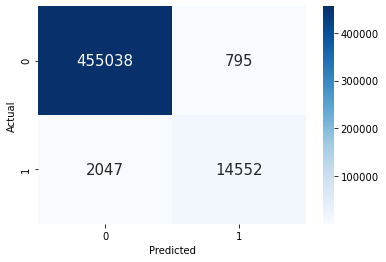

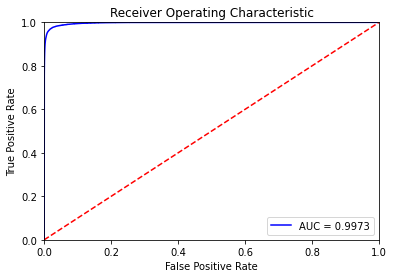

Train auc score:  0.9973352330432687


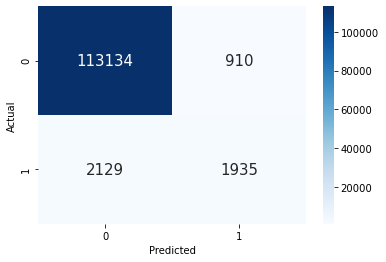

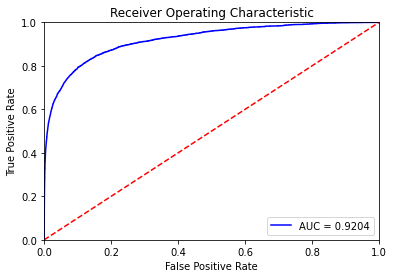

Test auc score:  0.9204426783784516


In [31]:

# plot results on train set
roc_auc = plot_roc_cm(y_train, y_predict_train)
print("Train auc score: ",roc_auc)
# plot results on valid set
roc_auc = plot_roc_cm(y_valid, y_predict_valid)
print("Test auc score: ", roc_auc)


In [32]:
# use sci-kit learn's SGDClassifier to implement Logistic Regression 
# Differed from LightGBM, the sci-kit learn library cannot deal with NaN value automatically
# we need to handle NaN values by hand
x_train = x_train.fillna(-5.1)
x_valid = x_valid.fillna(-5.1)


In [35]:
verbose = 0
# turn on verbose mode when debug mode is on
if DEBUG:
    verbose = 1
# scale the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

In [36]:
# ---------------------------------------#
# Use Grid Search cv to find best parameters
grid_search = False
if grid_search:    
    grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],  # learning rate
        'max_iter': [1000],  # number of epochs
        'penalty': ['l2','l1'],
        'n_jobs': [-1],
        'loss': ['log'],
        'random_state': [RANDOM_STATE],
        'verbose': [1],
        'class_weight': ['balanced', 'None']
    }
    clf = SGDClassifier()
    gsearch =GridSearchCV(clf,param_grid=grid,scoring='roc_auc',cv=3)
    gsearch.fit(x_scaled,y_train)
    best_parameters = gsearch.best_estimator_.get_params()
    cv_results = gsearch.cv_results_
    print(best_parameters)
    print(cv_results)


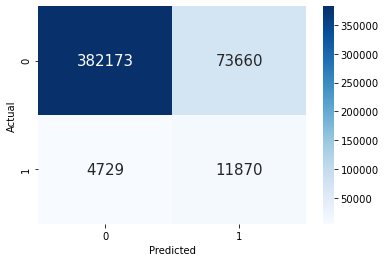

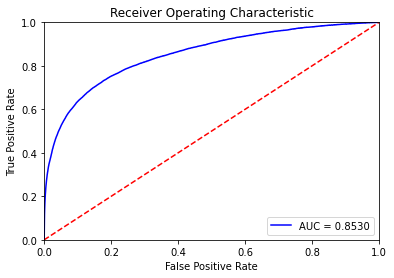

Train auc score:  0.8529735960838468


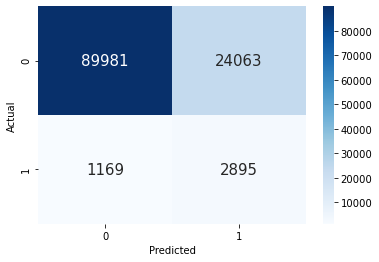

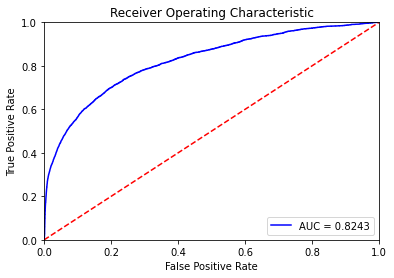

Valid auc score:  0.8242804480664598


In [37]:

# ------------------------------------------- #
# Logistic Regression with SGD
clf = SGDClassifier(alpha=0.001,max_iter=1000, loss='log', random_state=RANDOM_STATE,
                    class_weight='balanced', verbose = verbose
                    )
clf.fit(x_scaled, y_train)

y_train_predict = clf.predict_proba(x_scaled)
y_predict = clf.predict_proba(x_valid_scaled)
# plot results on train set
roc_auc = plot_roc_cm(y_train, y_train_predict[:,-1])
print("Train auc score: ", roc_auc)

# plot results on valid set
roc_auc = plot_roc_cm(y_valid, y_predict[:,-1])
print("Valid auc score: ", roc_auc)